## This notebook is for pre-processing liveability factor data

### 1. Setting up the coding environment

In [1]:
%reset -f

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

### 2. Reading and cleaning data

| Metric | Data | Unit | Year | Link |
| :- | -: | :- | :-: | :- |
| 0_Boundary | Boundary | Ward | 2013 | https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london |
| 1_Transportation | PTAL | Ward | 2013* | https://data.london.gov.uk/dataset/london-ward-well-being-scores |
| 2_Neighbourhood | Green and open space access | Ward | 2013* | (same as above) |
| 3_Opportunity | Average GCSE scores | Ward | 2013* | (same as above) |
| 4_Housing | Median house price | Ward | 2014 | https://data.london.gov.uk/dataset/ward-profiles-and-atlas |
| 0_Population | Population | Ward | 2015* | (same as above) |
| 5_Environment | Pollution impact | Ward | 2008* | https://data.london.gov.uk/dataset/estimation-health-impacts-particulate-pollution-london |
| 6_Safety | Residential bulgarly | Ward | 2009 | https://data.london.gov.uk/dataset/recorded_crime_summary |

In [3]:
# Initialise the dataframe to store all data
df_combined = pd.DataFrame()

#### 0. Boundary (2018)

In [4]:
file = os.path.join('data', 'raw', 'London-wards-2013', 'London_Ward.shp')

boundary = gpd.read_file(file)

<AxesSubplot:>

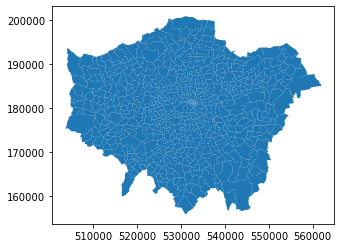

In [5]:
boundary.plot()

In [6]:
boundary.columns

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH',
       'POLY_ID', 'geometry'],
      dtype='object')

In [7]:
# Cleaning up
boundary.drop(['HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH', 'POLY_ID'], axis=1, inplace=True)

In [8]:
boundary.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      649 non-null    object  
 1   GSS_CODE  649 non-null    object  
 2   geometry  649 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 15.3+ KB


#### 1 & 2 & 3 - from well-being scores

In [9]:
# Reading in the data

file = os.path.join('data', 'raw', 'well_being_data.csv')
cols = ['Ward', 'New ward code',  'Public Transport Accessibility - 2013', 
        'Homes with access to open space & nature, and % greenspace - 2013',
        'GCSE point scores - 2013', ]

df_well_being = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [10]:
# Renaming columns
df_well_being.rename(columns={"Ward": "ward_name", 
                           "New ward code": "ward_code",
                           "GCSE point scores - 2013": "gcse_2013",
                           "Public Transport Accessibility - 2013": "ptal_2013",
                           "Homes with access to open space & nature, and % greenspace - 2013": 'nature_access_2013'},
                  inplace=True)

df_well_being.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ward_code           659 non-null    object 
 1   ward_name           657 non-null    object 
 2   gcse_2013           660 non-null    float64
 3   ptal_2013           659 non-null    float64
 4   nature_access_2013  659 non-null    float64
dtypes: float64(3), object(2)
memory usage: 27.9+ KB


In [11]:
df_well_being.head()

,ward_code,ward_name,gcse_2013,ptal_2013,nature_access_2013
0,NaN,NaN,NaN,NaN,NaN
1,E09000001,City of London,360.0,7.9,-6.5
2,E05000026,Abbey,334.0,6.0,-0.9
3,E05000027,Alibon,323.0,3.1,-1.8
4,E05000028,Becontree,319.0,2.9,-5.5


In [12]:
# Merge into the boundary data
df_merged_1 = pd.merge(boundary, df_well_being, left_on='GSS_CODE', right_on='ward_code', how='left')

# Cleaning up
df_merged_1.drop(['ward_code', 'ward_name'], axis=1, inplace=True)

In [13]:
df_merged_1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                649 non-null    object  
 1   GSS_CODE            649 non-null    object  
 2   geometry            649 non-null    geometry
 3   gcse_2013           624 non-null    float64 
 4   ptal_2013           624 non-null    float64 
 5   nature_access_2013  624 non-null    float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 35.5+ KB


In [14]:
#df_missing = df_merged[df_merged['ptal_2013'].isna()]
#df_missing

#### 4 - from ward atlas - Median House Price and Population

In [15]:
# Reading in the data

file = os.path.join('data', 'raw', 'ward_atlas.csv')
cols = ['Ward name', 'New code', 'Median House Price (£) - 2014', 'Population - 2015']

df_atlas = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [16]:
# Renaming columns
df_atlas.rename(columns={"Ward name": "ward_name", 
                           "New code": "ward_code",
                           "Median House Price (£) - 2014": "median_house_2014",
                           "Population - 2015": "population_2015"},
                  inplace=True)

df_atlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward_name          660 non-null    object 
 1   ward_code          660 non-null    object 
 2   population_2015    660 non-null    int64  
 3   median_house_2014  660 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 20.8+ KB


In [17]:
df_atlas['median_house_2014_log'] = np.log(df_atlas['median_house_2014'])

In [18]:
# Merge into the boundary data
df_merged_2 = pd.merge(df_merged_1, df_atlas, left_on='GSS_CODE', right_on='ward_code', how='left')

# Cleaning up
df_merged_2.drop(['ward_name', 'ward_code'], axis=1, inplace=True)

In [19]:
df_merged_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   NAME                   649 non-null    object  
 1   GSS_CODE               649 non-null    object  
 2   geometry               649 non-null    geometry
 3   gcse_2013              624 non-null    float64 
 4   ptal_2013              624 non-null    float64 
 5   nature_access_2013     624 non-null    float64 
 6   population_2015        624 non-null    float64 
 7   median_house_2014      624 non-null    float64 
 8   median_house_2014_log  624 non-null    float64 
dtypes: float64(6), geometry(1), object(2)
memory usage: 50.7+ KB


<AxesSubplot:>

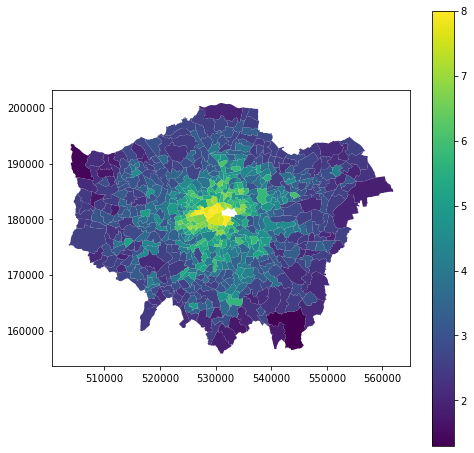

In [20]:
df_merged_2.plot(column='ptal_2013', legend=True, figsize=(8,8))

#### 5 - from pollution impact data

In [21]:
# Reading in the data

file = os.path.join('data', 'raw', 'air_pollution_mortality.csv')
cols = ['Area Code', 'Area Name', 'PM2.5 Concentration (µg/m3)']

df_pollution = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [22]:
# Renaming columns
df_pollution.rename(columns={"Area Code": "ward_code", 
                           "Area Name": "ward_name",
                           "PM2.5 Concentration (µg/m3)": "pollution_2008"},
                  inplace=True)

df_pollution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ward_code       626 non-null    object 
 1   ward_name       626 non-null    object 
 2   pollution_2008  626 non-null    float64
dtypes: float64(1), object(2)
memory usage: 14.8+ KB


In [23]:
df_missing = df_pollution[df_pollution['pollution_2008'].isna()]
df_missing

,ward_code,ward_name,pollution_2008


In [24]:
# change the name of ward in pollution data so it matches shape file
df_pollution.loc[[495], ['ward_name']] = 'Ham, Petersham and Richmond Riverside'

In [25]:
df_pollution.loc[[561], ['ward_name']] = 'St. Katharine\'s and Wapping'

In [26]:
df_pollution.loc[[597], ['ward_name']] = 'Roehampton and Putney Heath'

In [27]:
df_pollution.loc[[503], ['ward_name']] = 'St. Margarets and North Twickenham'

In [28]:
## Merge into the boundary data
df_merged_3 = pd.merge(df_merged_2, df_pollution, left_on='NAME', right_on='ward_name', how='left')

# Cleaning up
df_merged_3.drop(['ward_name', 'ward_code'], axis=1, inplace=True)

In [29]:
df_merged_3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 693 entries, 0 to 692
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   NAME                   693 non-null    object  
 1   GSS_CODE               693 non-null    object  
 2   geometry               693 non-null    geometry
 3   gcse_2013              668 non-null    float64 
 4   ptal_2013              668 non-null    float64 
 5   nature_access_2013     668 non-null    float64 
 6   population_2015        668 non-null    float64 
 7   median_house_2014      668 non-null    float64 
 8   median_house_2014_log  668 non-null    float64 
 9   pollution_2008         669 non-null    float64 
dtypes: float64(7), geometry(1), object(2)
memory usage: 59.6+ KB


<AxesSubplot:>

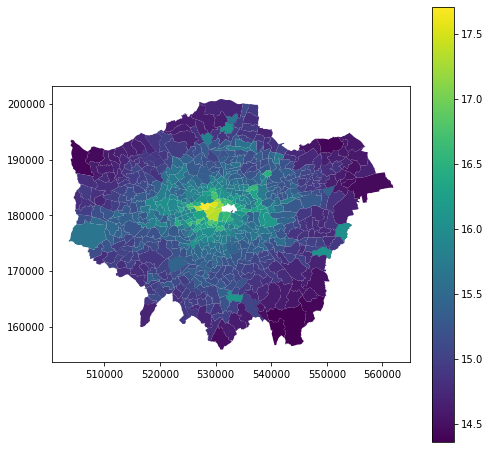

In [30]:
df_merged_3.plot(column='pollution_2008', legend=True, figsize=(8,8))

#### 6 - from crime data

In [31]:
# Reading in crime data

file = os.path.join('data', 'raw', 'MPS_Ward_Level_Crime_Historic_OldWardtoMar2010.csv')
cols = ['Ward Name', 'Ward Code', 'Minor Category', '200901', '200902', '200903', '200904',
       '200905', '200906', '200907', '200908', '200909', '200910', '200911', '200912']

df_crime = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [32]:
# Select only Domestic Burglary

df_crime = df_crime.loc[(df_crime['Minor Category'] == 'Burglary in a Dwelling')]

In [33]:
# Find the sum of Domestic Burglaries that happened in year 2014

df_crime['total2009'] = df_crime['200901'] + df_crime['200902'] + df_crime['200903'] + df_crime['200904'] + df_crime['200905'] + df_crime['200906'] + df_crime['200907'] + df_crime['200908'] + df_crime['200909'] + df_crime['200910'] + df_crime['200911'] + df_crime['200912']

In [34]:
df_crime = df_crime[['Ward Name', 'Ward Code', 'Minor Category', 'total2009']]

In [35]:
df_crime.head()

,Ward Name,Ward Code,Minor Category,total2009
1250,Abbey,E05000026,Burglary in a Dwelling,111
1251,Alibon,E05000027,Burglary in a Dwelling,91
1252,Becontree,E05000028,Burglary in a Dwelling,154
1253,Chadwell Heath,E05000029,Burglary in a Dwelling,127
1254,Eastbrook,E05000030,Burglary in a Dwelling,76


In [36]:
# Read in population data of wards

file = os.path.join('data', 'raw', 'housing-density-ward.csv')
cols = ['Code', 'Population', 'Year']

df_wardpop = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

# Filter out only year 2011
df_wardpop2011 = df_wardpop.loc[(df_wardpop['Year'] == 2011)]

In [37]:
df_wardpop2011.head()

,Code,Year,Population
0,E05000026,2011,12904
1,E05000027,2011,10468
2,E05000028,2011,11638
3,E05000029,2011,10098
4,E05000030,2011,10581


In [38]:
# do a left join - population data and crime

df_joinedcrime = pd.merge(df_crime, df_wardpop2011, left_on='Ward Code', right_on='Code', how='left')

In [39]:
# Normalise data per resident

df_joinedcrime['burglariesper1000residents'] = df_joinedcrime['total2009']/df_joinedcrime['Population']*1000

In [40]:
# Keep relevant columns

df_crimeNormalised = df_joinedcrime[['Ward Name', 'Ward Code', 'total2009', 'Population', 'burglariesper1000residents']]

In [41]:
df_crimeNormalised.head()

,Ward Name,Ward Code,total2009,Population,burglariesper1000residents
0,Abbey,E05000026,111,12904,8.601984
1,Alibon,E05000027,91,10468,8.693160
2,Becontree,E05000028,154,11638,13.232514
3,Chadwell Heath,E05000029,127,10098,12.576748
4,Eastbrook,E05000030,76,10581,7.182686


In [42]:
# Check if normalisation is accurate

df_crimeNormalised = df_crimeNormalised.sort_values(by=['burglariesper1000residents'], ascending=True)

In [43]:
df_crimeNormalised.head()

,Ward Name,Ward Code,total2009,Population,burglariesper1000residents
602,West Hill,E05000628,29,16472,1.760563
557,Millwall,E05000583,42,23383,1.796177
378,Chessington North and Hook,E05000404,19,8767,2.167218
430,Cannon Hill,E05000456,21,9307,2.256366
620,Vincent Square,E05000646,23,10003,2.299310


In [44]:
# Merge into the boundary data
df_merged_4 = pd.merge(df_merged_3, df_crimeNormalised, left_on='GSS_CODE', right_on='Ward Code', how='left')

# Cleaning up
df_merged_4.drop(['Ward Name', 'Ward Code','total2009', 'Population'], axis=1, inplace=True)

<AxesSubplot:>

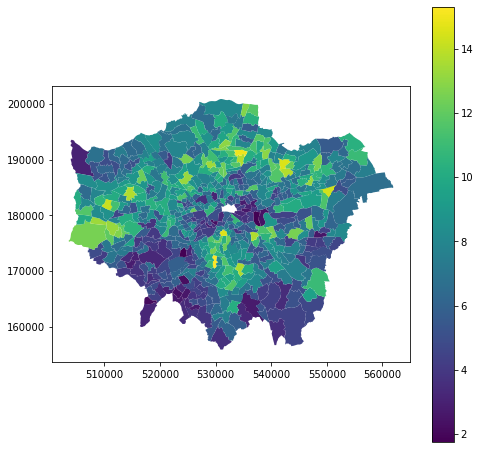

In [45]:
df_merged_4.plot(column='burglariesper1000residents', legend=True, figsize=(8,8))

In [46]:
df_merged_4.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 693 entries, 0 to 692
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   NAME                        693 non-null    object  
 1   GSS_CODE                    693 non-null    object  
 2   geometry                    693 non-null    geometry
 3   gcse_2013                   668 non-null    float64 
 4   ptal_2013                   668 non-null    float64 
 5   nature_access_2013          668 non-null    float64 
 6   population_2015             668 non-null    float64 
 7   median_house_2014           668 non-null    float64 
 8   median_house_2014_log       668 non-null    float64 
 9   pollution_2008              669 non-null    float64 
 10  burglariesper1000residents  668 non-null    float64 
dtypes: float64(8), geometry(1), object(2)
memory usage: 65.0+ KB


#### Finalise the dataframe and save as an output

In [47]:
# save
if not os.path.exists('data/clean'):
    os.mkdir('data/clean')

dest = os.path.join("data", "clean")
name = "df_data_pre_standardisation.csv"
file = os.path.join(dest, name)
df_merged_4.to_csv(file, index=False)

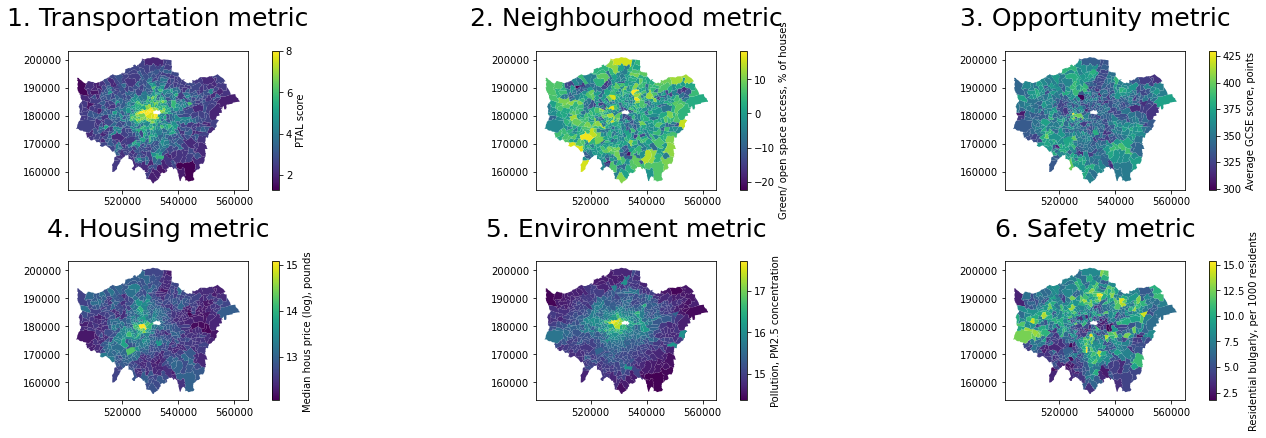

In [48]:
# Plot the distribution on histograms - code adapted from Phillip's 

cols_plot = ['ptal_2013','nature_access_2013', 'gcse_2013','median_house_2014_log', 
             'pollution_2008', 'burglariesper1000residents']

#set the histogram titles
titles = ["1. Transportation metric",
              "2. Neighbourhood metric",
              "3. Opportunity metric",
              "4. Housing metric",
              "5. Environment metric",
              "6. Safety metric"]

#set the axis labels
labels = ["PTAL score",
          "Green/ open space access, % of houses",
          "Average GCSE score, points",
          "Median hous price (log), pounds",
          "Pollution, PM2.5 concentration",
          "Residential bulgarly, per 1000 residents"]

#create a base axis for the plots
fig, ax = plt.subplots(2,3, figsize = (20,6))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(cols_plot):
    
    #add label information
    axis[i].set_title(titles[i], fontsize = 25, pad = 25)
    
    #create the plots
    df_merged_4.plot(column = col, legend = True, ax = axis[i], 
                     legend_kwds={'label': labels[i], 
                             'orientation': "vertical"})

#keep the layout tight
plt.tight_layout()
#show the plot 
plt.show()

### 3. Rescaling the data ready for clustering (Nene)

In [49]:
# Extract wards with all data existing
df_final = df_merged_4.dropna()

<AxesSubplot:>

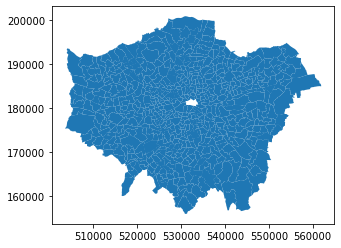

In [50]:
df_final.plot()

In [51]:
# Initialise the robust rescaler
rbs = RobustScaler(quantile_range=[0.01,0.99])
#mms = MinMaxScaler()

In [52]:
df_final.columns

Index(['NAME', 'GSS_CODE', 'geometry', 'gcse_2013', 'ptal_2013',
       'nature_access_2013', 'population_2015', 'median_house_2014',
       'median_house_2014_log', 'pollution_2008',
       'burglariesper1000residents'],
      dtype='object')

In [53]:
### Rescale ###
to_standardise = ['gcse_2013', 'ptal_2013', 'nature_access_2013',
                  'median_house_2014_log', 'pollution_2008', 'burglariesper1000residents']

# Store results here
df_standardised = gpd.GeoDataFrame()
df_standardised['NAME'] = df_final['NAME']
df_standardised['geometry'] = df_final['geometry']

for c in to_standardise:
    df_standardised[c] = rbs.fit_transform(df_final[c].values.reshape(-1,1))          # reshape changes shape, fit_transform makes Mean 0, sd 1

# Check
#df_standardised

In [54]:
# save
if not os.path.exists('data/clean'):
    os.mkdir('data/clean')

dest = os.path.join("data", "clean")
name = "df_data_standardised.csv"
file = os.path.join(dest, name)
df_standardised.to_csv(file, index=False)

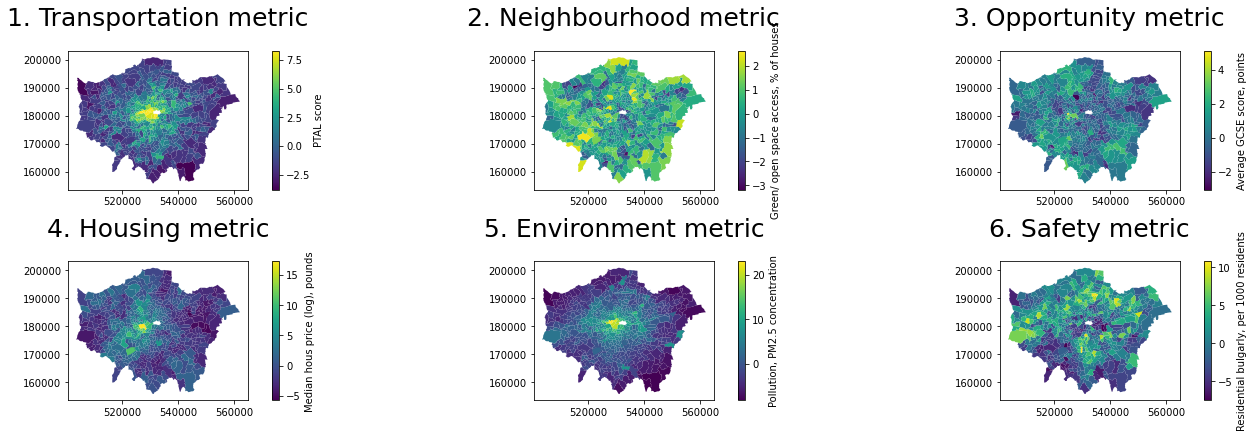

In [55]:
# Plot the distribution on histograms - code adapted from Phillip's 

cols_plot = ['ptal_2013','nature_access_2013', 'gcse_2013','median_house_2014_log', 
             'pollution_2008', 'burglariesper1000residents']

#set the histogram titles
titles = ["1. Transportation metric",
              "2. Neighbourhood metric",
              "3. Opportunity metric",
              "4. Housing metric",
              "5. Environment metric",
              "6. Safety metric"]

#set the axis labels
labels = ["PTAL score",
          "Green/ open space access, % of houses",
          "Average GCSE score, points",
          "Median hous price (log), pounds",
          "Pollution, PM2.5 concentration",
          "Residential bulgarly, per 1000 residents"]

#create a base axis for the plots
fig, ax = plt.subplots(2,3, figsize = (20,6))
#flatten the axis to make it easy to iteratre over
axis = ax.flatten()

#iterate over each columns using the labels information already set up
for i, col in enumerate(cols_plot):
    
    #add label information
    axis[i].set_title(titles[i], fontsize = 25, pad = 25)
    
    #create the plots
    df_standardised.plot(column = col, legend = True, ax = axis[i], 
                     legend_kwds={'label': labels[i], 
                             'orientation': "vertical"})

#keep the layout tight
plt.tight_layout()
#show the plot 
plt.show()

### 4. Creating statistical summary of the original data (Richy)

In [76]:
# find the mean

print(df_final['gcse_2013'].mean())
print(df_final['ptal_2013'].mean())
print(df_final['nature_access_2013'].mean())
print(df_final['median_house_2014_log'].mean())
print(df_final['pollution_2008'].mean())
print(df_final['burglariesper1000residents'].mean())



349.7694610778443
3.762125748502994
-0.19640718562874257
12.874662000396738
15.332739520958084
7.455736443418435


In [77]:
# find standard dev


print(df_final['gcse_2013'].std())
print(df_final['ptal_2013'].std())
print(df_final['nature_access_2013'].std())
print(df_final['median_house_2014_log'].std())
print(df_final['pollution_2008'].std())
print(df_final['burglariesper1000residents'].std())

17.890994987930465
1.3877876980317574
6.906283276229154
0.438150551860752
0.5477371833315391
2.658007204522549


In [75]:
# print the skew

print(df_final['gcse_2013'].skew())
print(df_final['ptal_2013'].skew())
print(df_final['nature_access_2013'].skew())
print(df_final['median_house_2014_log'].skew())
print(df_final['pollution_2008'].skew())
print(df_final['burglariesper1000residents'].skew())


0.40826717846156985
0.8959057216480153
-0.08307320051210544
1.0650882359082652
1.072517025321563
0.3653185781167771


<AxesSubplot:ylabel='Frequency'>

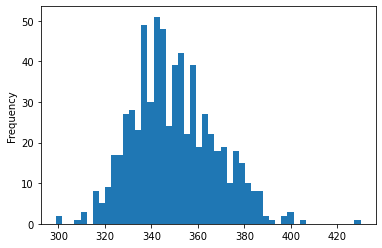

In [59]:
df_final.gcse_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

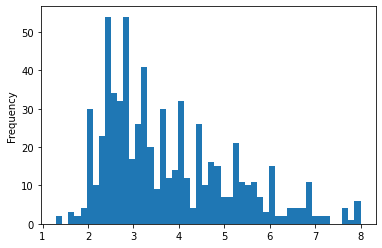

In [60]:
df_final.ptal_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

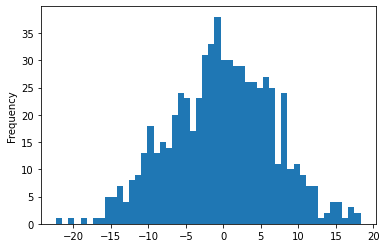

In [61]:
df_final.nature_access_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

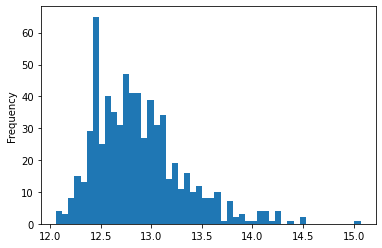

In [74]:
df_final.median_house_2014_log.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

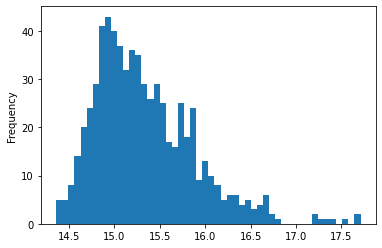

In [63]:
df_final.pollution_2008.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

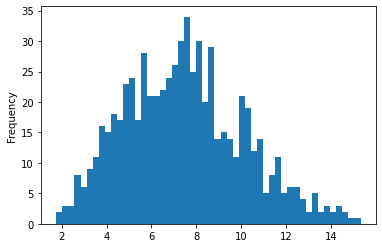

In [64]:
df_final.burglariesper1000residents.plot.hist(bins=50)

| Variable | Units | Mean | Skew | Sdv. |
| :- | :- | :-: | :-: | :-: |
| GCSE Scores | - | # | # | # |
| PTAL | Density score 0-9| # | # | # |
| Nature Access Scores | Homes with access to open space, <br> and proportion of area that is greenspace| # | # | # |
| Median House Price | £ | # | # | # |
| Air Pollution Mortality | Count | # | # | # |
| Total traffic accidents | Count | # | # | # |


### 5. Summarise statistical summary of the rescaled data (Richy)

In [65]:
# find the mean

print(df_standardised['gcse_2013'].mean())
print(df_standardised['ptal_2013'].mean())
print(df_standardised['nature_access_2013'].mean())
print(df_standardised['median_house_2014_log'].mean())
print(df_standardised['pollution_2008'].mean())
print(df_standardised['burglariesper1000residents'].mean())

0.11059131736526946
0.6540579931781134
-0.01383848442981404
0.4910396119785343
0.9097803350778485
0.19363695092707003


In [66]:
# find the standard dev

print(df_standardised['gcse_2013'].std())
print(df_standardised['ptal_2013'].std())
print(df_standardised['nature_access_2013'].std())
print(df_standardised['median_house_2014_log'].std())
print(df_standardised['pollution_2008'].std())
print(df_standardised['burglariesper1000residents'].std())

1.118187186745654
2.5065702742328466
0.9913420142148472
3.3474083695350956
5.098454681394125
3.585307951042196


In [67]:
# find the skew

print(df_standardised['gcse_2013'].skew())
print(df_standardised['ptal_2013'].skew())
print(df_standardised['nature_access_2013'].skew())
print(df_standardised['median_house_2014_log'].skew())
print(df_standardised['pollution_2008'].skew())
print(df_standardised['burglariesper1000residents'].skew())

0.40826717846156985
0.8959057216480151
-0.08307320051210583
1.0650882359082485
1.072517025321563
0.36531857811677637


<AxesSubplot:ylabel='Frequency'>

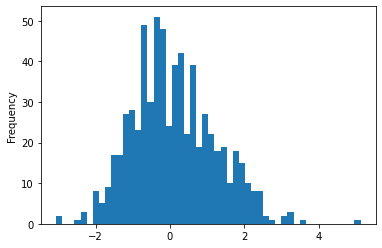

In [68]:
df_standardised.gcse_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

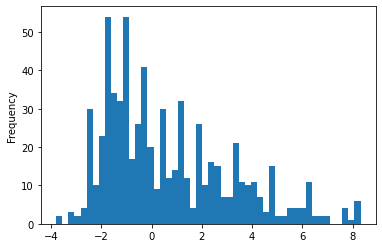

In [69]:
df_standardised.ptal_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

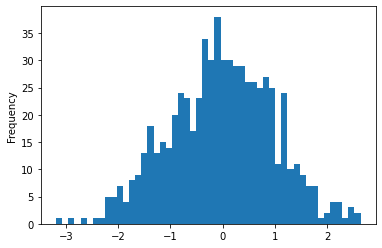

In [70]:
df_standardised.nature_access_2013.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

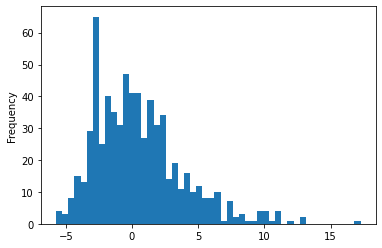

In [71]:
df_standardised.median_house_2014_log.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

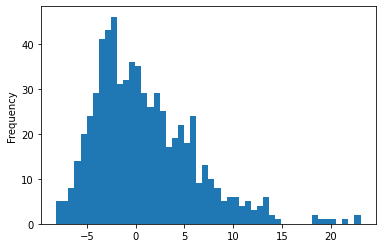

In [72]:
df_standardised.pollution_2008.plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

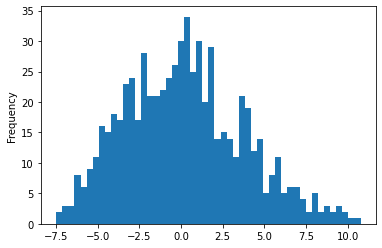

In [73]:
df_standardised.burglariesper1000residents.plot.hist(bins=50)